In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

data_path = 'D:\galaxy_classification\data2.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'EDGE': 2, 'STAR': 3}

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

def image_generator(data, batch_size, image_dir, class_mapping, augment=False):
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    num_samples = data.shape[0]
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data.iloc[offset:offset+batch_size]
            
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image_id = row['image_id']
                label = row['class']
                
                image_path = os.path.join(image_dir, f"{image_id}.jpg")
                
                if os.path.exists(image_path):
                    img = load_img(image_path, target_size=(128, 128))
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(class_mapping[label])
            
            X = np.array(images)
            y = to_categorical(np.array(labels), num_classes=len(class_mapping))
            
            if augment:
                yield next(datagen.flow(X, y, batch_size=batch_size))
            else:
                yield X, y

batch_size = 64

train_generator = image_generator(train_data, batch_size, image_dir, class_mapping, augment=True)
val_generator = image_generator(val_data, batch_size, image_dir, class_mapping, augment=False)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 데이터 제너레이터 테스트
X_test, y_test = next(train_generator)
print(f"Batch X shape: {X_test.shape}, Batch y shape: {y_test.shape}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0

In [2]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_data) // batch_size,
    verbose=1
)

Epoch 1/10
2994/2994 [==============================] - 1725s 576ms/step - loss: 0.6784 - accuracy: 0.7019 - val_loss: 0.5157 - val_accuracy: 0.7765
Epoch 2/10
2994/2994 [==============================] - 1792s 599ms/step - loss: 0.5393 - accuracy: 0.7691 - val_loss: 0.4971 - val_accuracy: 0.7839
Epoch 3/10
2994/2994 [==============================] - 1850s 618ms/step - loss: 0.5109 - accuracy: 0.7803 - val_loss: 0.4909 - val_accuracy: 0.7826
Epoch 4/10
2994/2994 [==============================] - 1836s 613ms/step - loss: 0.4923 - accuracy: 0.7878 - val_loss: 0.5079 - val_accuracy: 0.7745
Epoch 5/10
2994/2994 [==============================] - 1880s 628ms/step - loss: 0.4827 - accuracy: 0.7927 - val_loss: 0.4466 - val_accuracy: 0.8062
Epoch 6/10
2994/2994 [==============================] - 1865s 623ms/step - loss: 0.4744 - accuracy: 0.7964 - val_loss: 0.4409 - val_accuracy: 0.8100
Epoch 7/10
2994/2994 [==============================] - 1814s 606ms/step - loss: 0.4699 - accuracy: 0.7979

In [3]:
model.save('D:\galaxy_classification\galaxy_classifier_ver7.h5')

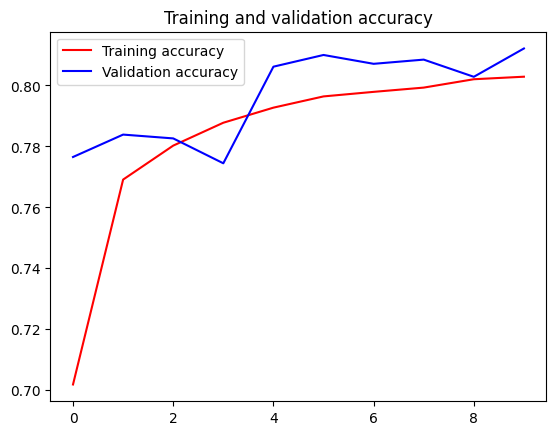

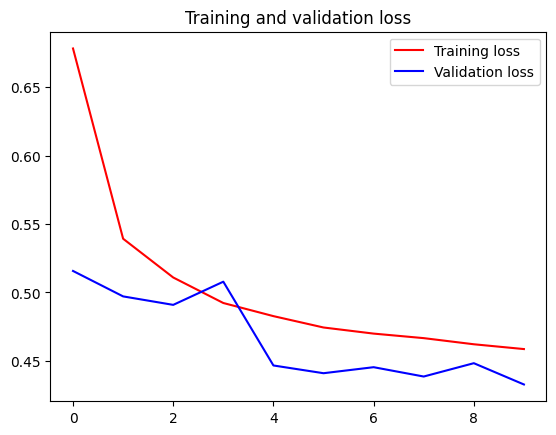

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

C:\Users\hyeonwoo\anaconda\envs\hw\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


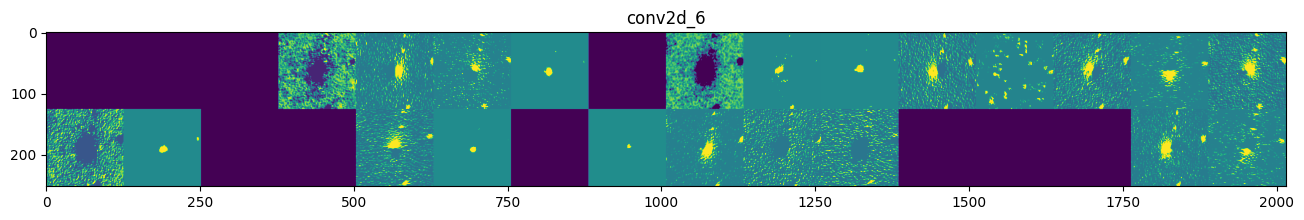

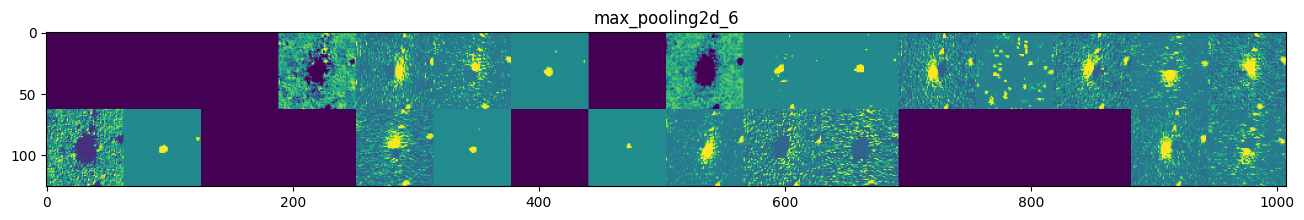

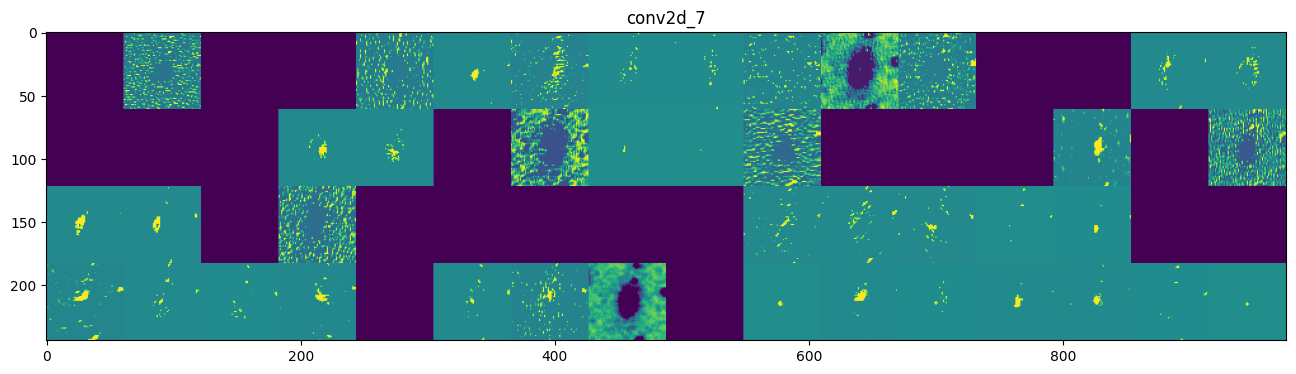

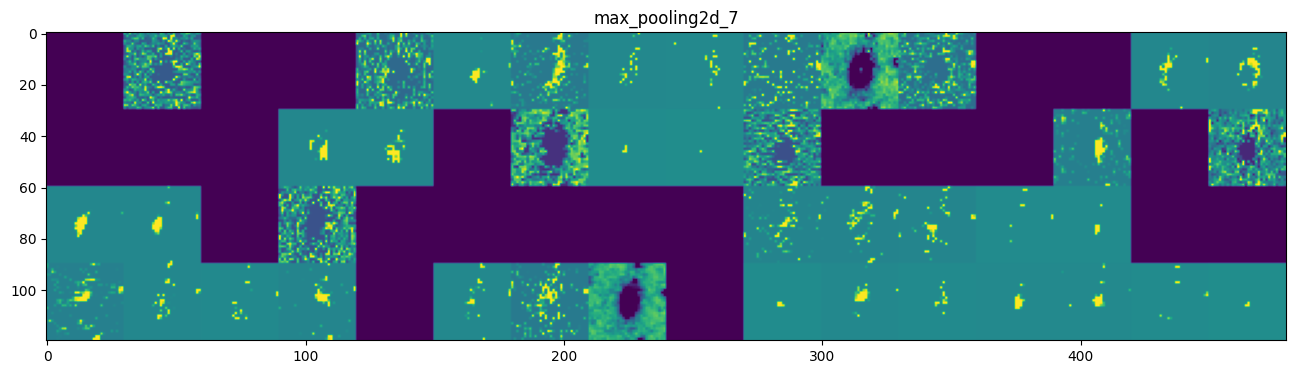

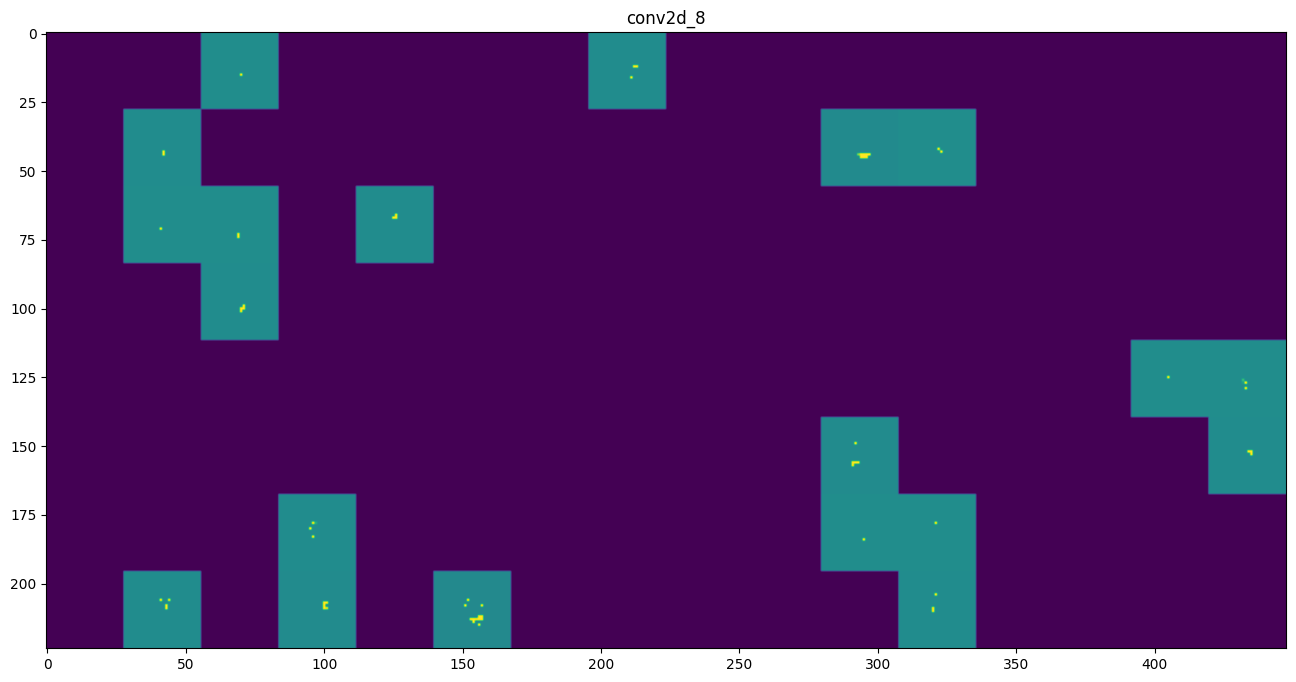

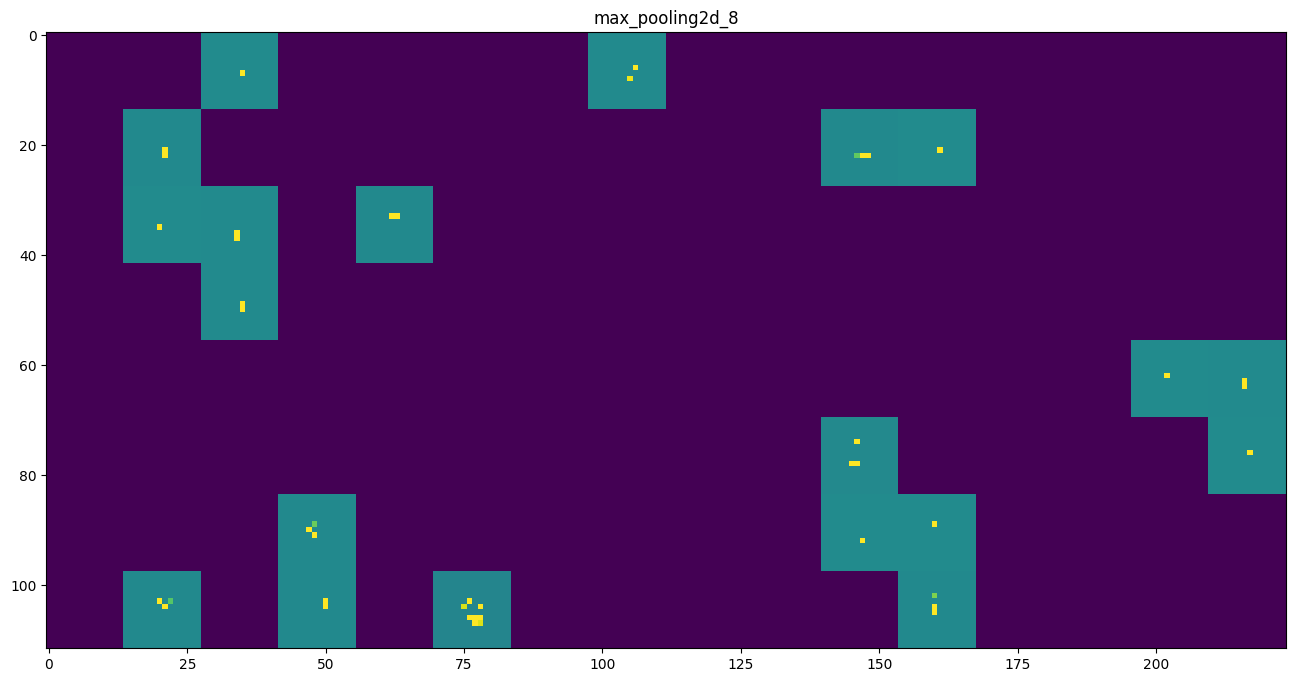

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

data_path = 'D:\galaxy_classification\data2.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'SB': 2, 'EDGE': 3}

model_path = 'D:\galaxy_classification\galaxy_classifier.h5'
model = load_model(model_path)

layer_outputs = [layer.output for layer in model.layers[:6]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)

image_id = data.iloc[0]['image_id'] 
img_path = os.path.join(image_dir, f"{image_id}.jpg")
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

activations = activation_model.predict(img_array)

layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name) 

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] 
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

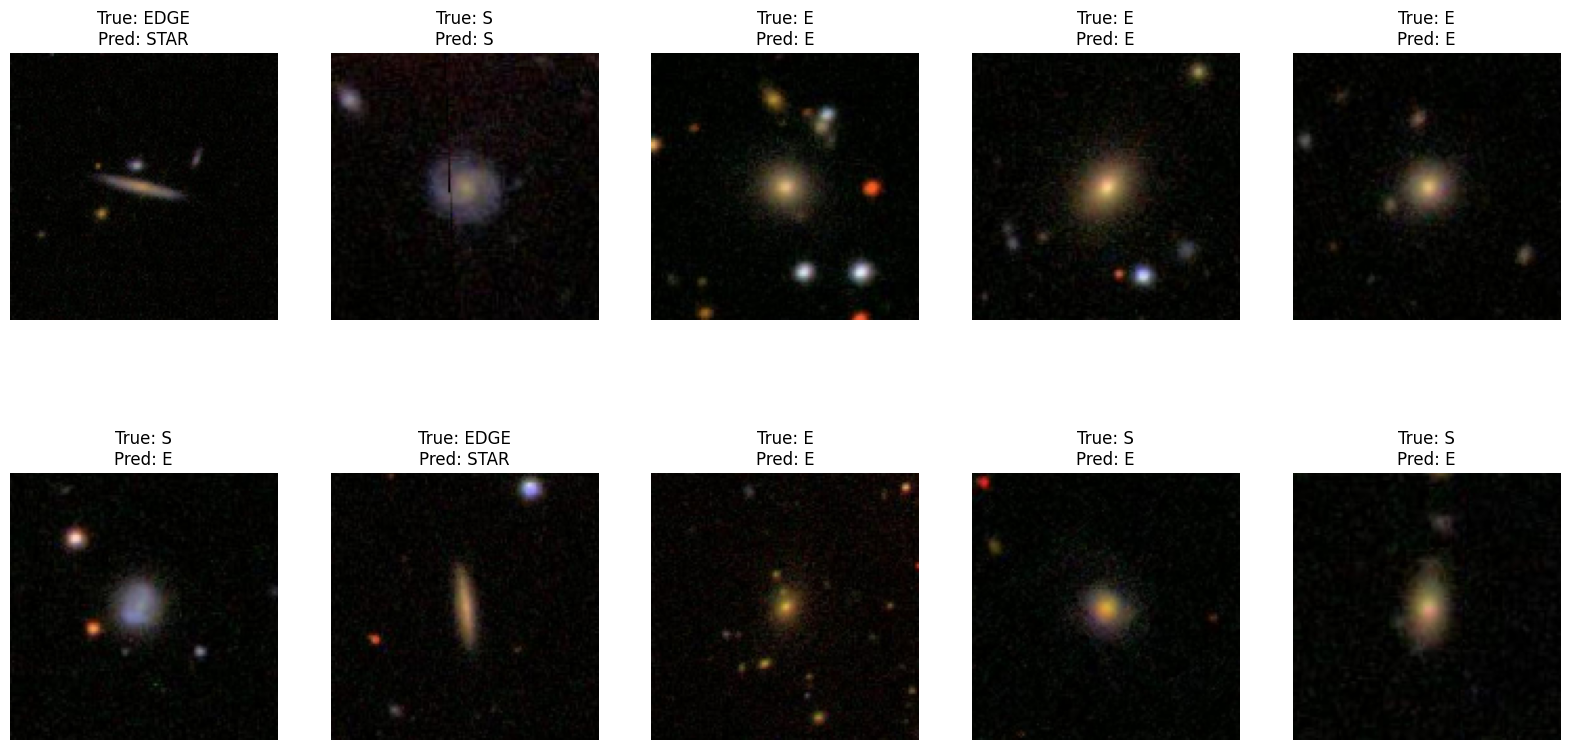

In [10]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

data_path = 'D:\galaxy_classification\data2.csv'
image_dir = 'D:\galaxy_classification\images'

data = pd.read_csv(data_path)

class_mapping = {'S': 0, 'E': 1, 'EDGE': 2, 'STAR': 3}

from sklearn.model_selection import train_test_split
_, val_data = train_test_split(data, test_size=0.2, random_state=42)

model_path = 'D:\galaxy_classification\galaxy_classifier_ver4.h5'

model = load_model(model_path)

def compare_predictions(model, data, image_dir, class_mapping, num_samples=10):
    samples = data.sample(n=num_samples)
    plt.figure(figsize=(20, 10))

    for i, (_, row) in enumerate(samples.iterrows()):
        image_id = row['image_id']
        true_label = row['class']
        
        image_path = os.path.join(image_dir, f"{image_id}.jpg")
        
        if os.path.exists(image_path):
            img = load_img(image_path, target_size=(128, 128))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            
            inv_class_mapping = {v: k for k, v in class_mapping.items()}
            predicted_label = inv_class_mapping[predicted_class]
            
            plt.subplot(2, num_samples // 2, i + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')

    plt.show()

compare_predictions(model, val_data, image_dir, class_mapping, num_samples=10)


In [1]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# 검증 데이터 전체 예측
val_steps = len(val_data) // batch_size + 1
y_pred_prob = model.predict(val_generator, steps=val_steps)

# 실제 라벨 추출
y_true = val_data['class'].apply(lambda x: class_mapping[x]).values[:len(y_pred_prob)]

# 이진화된 라벨
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

# 각 클래스별 ROC 커브 및 AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC 커브 및 AUC 계산
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ROC 커브 그리기
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(class_mapping)):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


NameError: name 'val_data' is not defined